In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 设置matplotlib的中文显示和负号显示
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 忽略警告
warnings.filterwarnings("ignore")

# 尝试使用不同的编码读取数据
try:
    # 尝试使用utf-8编码读取
    data = pd.read_csv(r'D:\2067455485\FileRecv\data.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        # 如果utf-8失败，尝试使用GBK编码读取
        data = pd.read_csv(r'D:\2067455485\FileRecv\data.csv', encoding='gbk')
    except UnicodeDecodeError:
        # 如果GBK也失败，尝试使用ISO-8859-1编码读取
        data = pd.read_csv(r'D:\2067455485\FileRecv\data.csv', encoding='ISO-8859-1')
    except Exception as e:
        print(f"读取文件时遇到错误：{e}")

# 显示数据的前几行
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
# 查看数据集基本信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [3]:
# 删除重复值
data.drop_duplicates(inplace=True)
data.shape[0]  # 536641
# 查看缺失值数量与比例
(
pd.DataFrame({
        "NaN_num": round(data.isnull().sum(),2),
        "NaN_percent":(data.isnull().sum()/data.shape[0]).apply(lambda x:str(round(x*100,2))+'%') ,
            })
  .sort_values('NaN_num', ascending=False)
)


,NaN_num,NaN_percent
CustomerID,135037,25.16%
Description,1454,0.27%
StockCode,0,0.0%
InvoiceNo,0,0.0%
Quantity,0,0.0%
InvoiceDate,0,0.0%
UnitPrice,0,0.0%
Country,0,0.0%


In [4]:
# 查看用户编号为缺失值的数据，找到其InvoiceNo订单编号
CustomerID_isnull_list = data.loc[data['CustomerID'].isnull()].InvoiceNo.unique().tolist()
# 查看用户编号为非缺失值的列，找到其InvoiceNo订单编号
CustomerID_notnull_list = data.loc[~data['CustomerID'].isnull()].InvoiceNo.unique().tolist()
# 查看两者交集--即缺失值中没有订单编号与未缺失的相同
[i for i in CustomerID_isnull_list if i in CustomerID_notnull_list]


[]

In [5]:
# 删除CustomerID缺失值
data.dropna(subset=['CustomerID'], how='any', inplace=True)

In [6]:
# 将日期字符串格式转换成时间格式
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, format='%m/%d/%Y %H:%M')
# 查看是否有日期不在选定日期范围内的数据
data.query(" InvoiceDate < '2010-12-01' | InvoiceDate > '2011-12-10'")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [7]:
# 描述性统计
data[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [8]:
# 删除单价为0的数据
data.drop(data.query("UnitPrice == 0 ").index, inplace=True)
# 查看数量为负且InvoiceNo订单编号没有C的数量
print(data.query("Quantity < 0 & ~InvoiceNo.str.contains('C')", engine='python').InvoiceNo.count())
# 查看数量为不为负且且InvoiceNo订单编号含有C的数量
print(data.query("Quantity >= 0 & InvoiceNo.str.contains('C')", engine='python').InvoiceNo.count())

0
0


In [9]:
# 查看数量为负的订单
data.query(" Quantity < 0").head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom


In [10]:
# 筛选并拼接数量为负的订单信息
data_return = data.query(" Quantity < 0")
data_return['return'] = data_return.InvoiceNo.str.split("C", expand=True)[1] + data_return.StockCode + \
                        data_return.Description + abs(data_return.Quantity).astype("str") + \
                        data_return.UnitPrice.astype("str") + data_return.CustomerID.astype("str")
# 筛选并拼接数量为正的订单信息      
data_sale = data.query(" Quantity > 0").astype("str")
data_sale['sale'] = data_sale.InvoiceNo + data_sale.StockCode + data_sale.Description + data_sale.Quantity + \
                        data_sale.UnitPrice + data_sale.CustomerID           
# 利用intersection方法查看是否有交集
set(data_return['return'].tolist()).intersection(set(data_sale['sale'].tolist()))                              

set()

In [11]:
# 删除退货订单信息
data.drop(data.query("Quantity <= 0 ").index, inplace=True)

In [12]:
# 添加总价列
data['Monetary'] = data['Quantity'] * data['UnitPrice']
# 添加年、月、日 、日期列
data['Date'] = data['InvoiceDate'].dt.date
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary,Date,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010,12,1


In [13]:
# RFM模型
# 定义一个分箱之后的统计函数
def rfm_bins_statistics(feature, scores, name):
    feature_statistic = pd.concat([feature, data.groupby('CustomerID').Monetary.sum(), scores], axis=1)
    feature_statistic.columns = [name, 'Monetary', 'label']
    feature_bins = feature_statistic.groupby('label')[name].max().tolist()
    feature_bins_min = [-1] + feature_bins[:-1]  # 辅助列
    feature_label_statistic = feature_statistic.groupby('label').agg({
        '{}'.format(name): ['count', ('占比', lambda x: "%.1f" % ((x.count() / feature_statistic[name].count() * 100)) + '%')],
        'Monetary': ['sum', ('占比', lambda x: "%.1f" % ((x.sum() / feature_statistic.Monetary.sum() * 100)) + '%')]
    }).assign(范围=[str(i + 1) + '-' + str(j) for i, j in zip(feature_bins_min, feature_bins)])
    return feature_statistic, feature_label_statistic, feature_bins

# 假设您已经有了一个特征DataFrame和标签DataFrame，您可以这样调用函数：
# 例如，如果您想根据'Monetary'列来分箱，并且已经有了一个'scores' DataFrame来表示每个客户的RFM得分：
# feature = data[['CustomerID', 'InvoiceDate']]  # 假设您已经有了基于'CustomerID'和'InvoiceDate'计算出的特征
# scores = pd.DataFrame(data.groupby('CustomerID').Monetary.sum().rank(method='dense'), columns=['label'])
# rfm_feature_statistic, rfm_label_statistic, rfm_bins = rfm_bins_statistics(feature, scores, 'RFM_feature')

In [14]:
#R
# 计算每个客户购买的最近日期
R = data.groupby('CustomerID')['InvoiceDate'].max()

# 计算每位客户最近一次购买距离截止日期的天数
# 确保'InvoiceDate'列是datetime类型
R_days = (data['InvoiceDate'].max() - R).dt.days  # .dt.days取出days

# 数据非正态分布，将客户最近一次购买天数按照中位数分5层，并依次评分
# 上一次消费距离天数越近越好，所以labels为倒序
R_scores = pd.qcut(R_days, q=5, duplicates='drop', labels=[5, 4, 3, 2, 1])

In [15]:
R_statistic, R_label_statistic, R_bins = rfm_bins_statistics(R_days, R_scores, 'Date')
R_label_statistic

Date            Monetary              范围
      count     占比          sum     占比         
label                                          
5       868  20.0%  4653608.380  52.4%     0-12
4       904  20.8%  1817778.971  20.5%    13-32
3       858  19.8%  1099446.880  12.4%    33-71
2       843  19.4%   758624.772   8.5%   72-178
1       865  19.9%   557749.891   6.3%  179-373

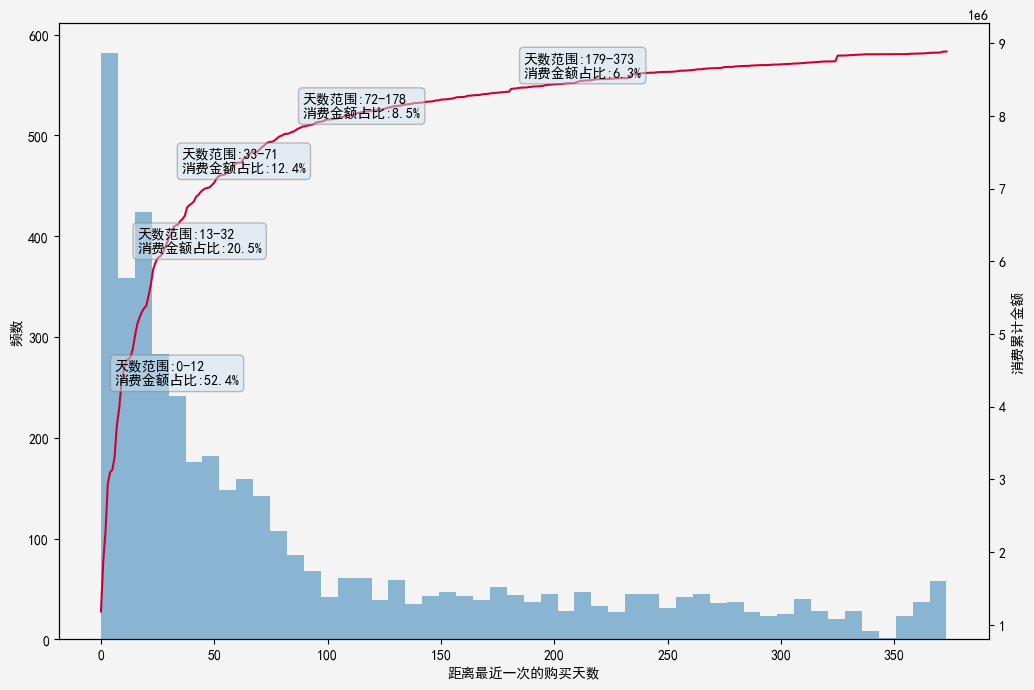

In [16]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig,ax = plt.subplots(figsize=(12, 8), facecolor='#f4f4f4')

# 各天数的消费金额之和
Monetary_sum = pd.concat([R_statistic.Date.value_counts().sort_index(), R_statistic.groupby('Date').Monetary.sum()], axis=1)
# 层级消费金额按照天数范围从小到大的累计之和---sumsum不是sum
Monetary_range = R_label_statistic['Monetary', 'sum'].cumsum().tolist()
# 频数分布图
ax.hist(R_statistic.Date, bins=50, alpha=0.5)  
ax1 = ax.twinx()
ax1.plot(Monetary_sum.Monetary.cumsum(), color='#cc0033')
# 文字标注
for i in range(5):
    ax1.text(
        R_bins[i]/2,
        Monetary_range[i],
        '天数范围:' + str(R_label_statistic['范围'].tolist()[i])+ '\n' + '消费金额占比:' + str(R_label_statistic['Monetary','占比'].tolist()[i]),
        va='top',
        ha='left',
        bbox={'boxstyle': 'round',
              'edgecolor':'grey',
              'facecolor':'#d1e3ef',
              'alpha':0.5})
# # 矩形
# polygons = [Polygon(xy=np.array([(0, 0), (R_bins[0], 0), (R_bins[0], Monetary_range[0]), (0,Monetary_range[0])])),
#             Polygon(xy=np.array([(R_bins[0], Monetary_range[0]), (R_bins[1], Monetary_range[0]), (R_bins[1], Monetary_range[1]), (R_bins[0], Monetary_range[1])])),
#             Polygon(xy=np.array([(R_bins[1], Monetary_range[1]), (R_bins[2], Monetary_range[1]), (R_bins[2], Monetary_range[2]), (R_bins[1], Monetary_range[2])])),
#             Polygon(xy=np.array([(R_bins[2], Monetary_range[2]), (R_bins[3], Monetary_range[2]), (R_bins[3], Monetary_range[3]), (R_bins[2], Monetary_range[3])])),
#             Polygon(xy=np.array([(R_bins[3], Monetary_range[3]), (R_bins[4], Monetary_range[3]), (R_bins[4], Monetary_range[4]), (R_bins[3], Monetary_range[4])]))]

# ax1.add_collection(PatchCollection(polygons, facecolor='grey', alpha=0.3));

ax.set_xlabel('距离最近一次的购买天数')
ax.set_ylabel('频数')
ax1.set_ylabel('消费累计金额')
ax.set_facecolor('#f4f4f4')
plt.show()


In [17]:
#F
# 计算每个客户购买的频次---一天内多次消费算一次，按照天数计次
F = data.groupby('CustomerID')['Date'].nunique()
# 查看消费次数占比
pd.DataFrame({'count':F.value_counts(),
             'percent':F.value_counts()/F.value_counts().sum()}).head(5)
# 自定义边界分箱
F_scores = pd.cut(F,[1, 2, 3, 5, 8, F.max()+1], labels=[1, 2, 3, 4, 5], right=False)  # 消费频次越大越好，所以labels为顺序
# 查看相关统计
F_statistic, F_label_statistic, F_bins = rfm_bins_statistics(F, F_scores, 'Freq')
F_label_statistic


Freq            Monetary            范围
      count     占比          sum     占比       
label                                        
1      1548  35.7%   702011.511   7.9%    0-1
2       874  20.1%   866997.951   9.8%    2-2
3       890  20.5%  1177767.232  13.3%    3-4
4       543  12.5%  1348193.890  15.2%    5-7
5       483  11.1%  4792238.310  53.9%  8-132

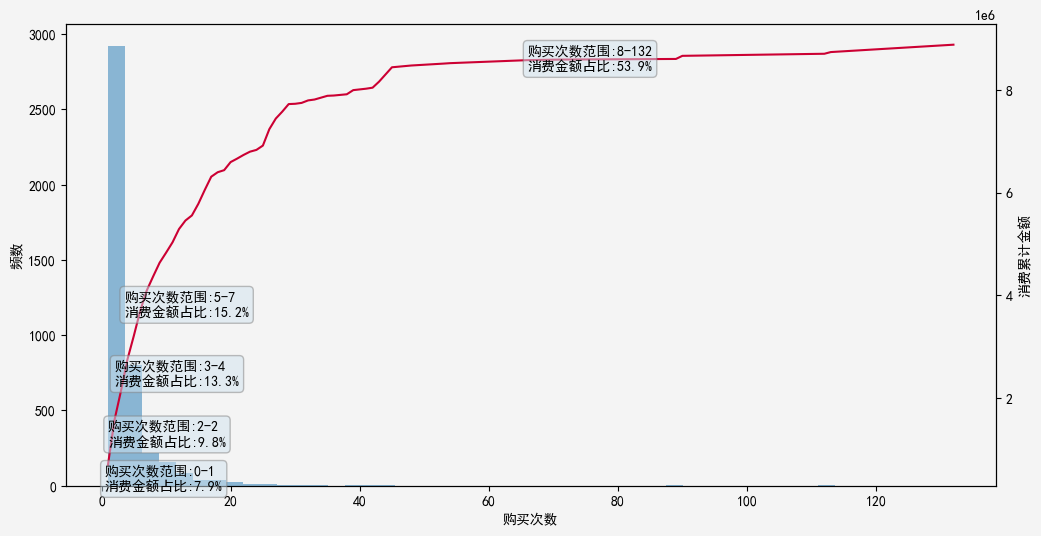

In [18]:
# 绘图
fig,ax = plt.subplots(figsize=(12, 6), facecolor='#f4f4f4')
# 各天数的消费金额之和
Monetary_sum = pd.concat([F_statistic.Freq.value_counts().sort_index(), F_statistic.groupby('Freq').Monetary.sum()], axis=1)
# 层级消费金额按照天数范围从小到大的累计之和---sumsum不是sum
Monetary_range = F_label_statistic['Monetary', 'sum'].cumsum().tolist()
# 频数分布图
ax.hist(F_statistic.Freq, bins=50, alpha=0.5)  
ax1 = ax.twinx()
ax1.plot(Monetary_sum.Monetary.cumsum(), color='#cc0033')
# 文字标注
for i in range(5):
    ax1.text(
        F_bins[i]/2,
        Monetary_range[i],
        '购买次数范围:' + str(F_label_statistic['范围'].tolist()[i])+ '\n' + '消费金额占比:' + str(F_label_statistic['Monetary','占比'].tolist()[i]),
        va='top',
        ha='left',
        bbox={'boxstyle': 'round',
              'edgecolor':'grey',
              'facecolor':'#d1e3ef',
              'alpha':0.5})
ax.set_xlabel('购买次数')
ax.set_ylabel('频数')
ax1.set_ylabel('消费累计金额')
ax.set_facecolor('#f4f4f4')
plt.show()


In [19]:
#M
# 将每层按照中位数分5层，并依次评分
M = data.groupby('CustomerID')['Monetary'].sum()  
M_scores =  pd.qcut(M, q=5, duplicates='drop',labels=[1,2,3,4,5])  # 消费金额越大越好，所以labels为顺序
# 查看相关统计
M_statistic = pd.concat([data.groupby('CustomerID').Monetary.sum(), M_scores], axis=1)
M_statistic.columns = ['Monetary', 'label']
M_label_statistic = M_statistic.groupby('label').agg({
            'label':['count',('占比', lambda x: x.count() / M_statistic.label.count())],
            'Monetary':['sum',('占比', lambda x: x.sum() / M_statistic.Monetary.sum())],
        }).sort_values(('Monetary','sum'),ascending = False).round(2)
M_label_statistic

label         Monetary      
      count   占比         sum    占比
label                             
5       868  0.2  6637300.82  0.75
4       867  0.2  1213460.91  0.14
3       868  0.2   594005.68  0.07
2       867  0.2   310003.31  0.03
1       868  0.2   132438.17  0.01

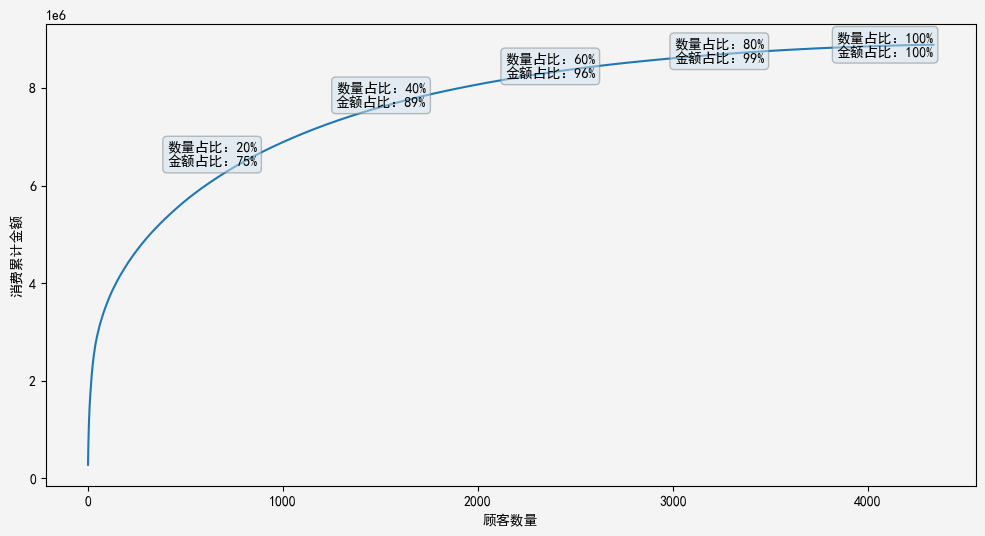

In [20]:
# 绘图
fig,ax = plt.subplots(figsize=(12, 6), facecolor='#f4f4f4')

label_count_cumsum = M_label_statistic.cumsum()['label', 'count'].values
label_percent_cumsum = M_label_statistic.cumsum()['label', '占比'].values
Monetary_sum_cumsum = M_label_statistic.cumsum()['Monetary', 'sum'].values
Monetary_percent_cumsum = M_label_statistic.cumsum()['Monetary', '占比'].values

ax.plot(M_statistic.Monetary.sort_values(ascending=False).cumsum().values)
for i in range(5):
    ax.text(label_count_cumsum[i],
            Monetary_sum_cumsum[i],
            '数量占比：%.0f%%'%(label_percent_cumsum[i]*100)+'\n'+'金额占比：%.0f%%'%(Monetary_percent_cumsum[i]*100), 
            va='center', 
            ha='right',
            bbox={
                'boxstyle': 'round',
                'edgecolor':'grey',
                'facecolor':'#d1e3ef',
                'alpha':0.5 })
ax.set_xlabel('顾客数量')
ax.set_ylabel('消费累计金额')
ax.set_facecolor('#f4f4f4')
plt.show()


In [21]:
# 合并
RFM = pd.concat([R_scores,F_scores,M_scores],axis=1)
RFM.columns = ['R_scores', 'F_scores', 'M_scores']
# 绘制R F M 得分交叉表
pd.pivot_table(RFM, index = ['R_scores','F_scores'], columns=['M_scores'], aggfunc=len)

M_scores               1      2     3      4      5
R_scores F_scores                                  
5        1          38.0   23.0   7.0    1.0    2.0
         2          16.0   42.0  42.0   22.0    4.0
         3           3.0   13.0  62.0   71.0   31.0
         4           2.0    1.0  12.0   86.0   90.0
         5           NaN    NaN   1.0   30.0  269.0
4        1          94.0   63.0  20.0    6.0    2.0
         2          18.0   59.0  70.0   27.0    6.0
         3           NaN   17.0  77.0  107.0   35.0
         4           NaN    1.0  15.0   82.0   79.0
         5           NaN    NaN   1.0   13.0  112.0
3        1         130.0  108.0  45.0   17.0    4.0
         2          23.0   52.0  76.0   32.0   11.0
         3           6.0   14.0  69.0   79.0   42.0
         4           NaN    1.0  10.0   44.0   54.0
         5           NaN    NaN   1.0   11.0   29.0
2        1         146.0  108.0  64.0   23.0    4.0
         2          26.0   54.0  90.0   40.0   10.0
         3           5.0   27.0  63.0   86.0   28.0
         4           1.0    1.0   5.0   22.0   26.0
         5           NaN    NaN   2.0    3.0    9.0
1        1         340.0  212.0  61.0   24.0    6.0
         2          17.0   56.0  49.0   25.0    7.0
         3           3.0   14.0  23.0   11.0    4.0
         4           NaN    1.0   3.0    4.0    3.0
         5           NaN    NaN   NaN    1.0    1.0

In [22]:
# 格式转换
for i in RFM.columns:
    RFM[i] = RFM[i].astype(float)

# 将每个值按照R/F/M均值大小分别定义其价值高低
for i,j in enumerate(['R', 'F', 'M']):
    RFM[j] = np.where(RFM.iloc[:,i] > RFM.iloc[:,i].mean(), '高', '低')

# 创造综合价值变量
RFM['Value'] = RFM['R'] + RFM['F'] +RFM['M'] 

map_dict = {'高高高':'重要价值客户', '高低高':'重要发展客户', '低高高':'重要保持客户', '低低高':'重要挽留客户','高高低':'一般价值客户', '高低低':'一般发展客户', '低高低':'一般保持客户', '低低低':'流失客户'}
RFM['CustmerLevel'] = RFM['Value'].map(map_dict)
RFM.head()


,R_scores,F_scores,M_scores,R,F,M,Value,CustmerLevel
CustomerID,,,,,,,,
12346.0,1.0,1.0,5.0,低,低,高,低低高,重要挽留客户
12347.0,5.0,4.0,5.0,高,高,高,高高高,重要价值客户
12348.0,2.0,3.0,4.0,低,高,高,低高高,重要保持客户
12349.0,4.0,1.0,4.0,高,低,高,高低高,重要发展客户
12350.0,1.0,1.0,2.0,低,低,低,低低低,流失客户


In [23]:
# 合并
RFM = pd.concat([R_scores,F_scores,M_scores],axis=1)
RFM.columns = ['R_scores', 'F_scores', 'M_scores']

# 绘制R F M 得分交叉表
pd.pivot_table(RFM, index = ['R_scores','F_scores'], columns=['M_scores'], aggfunc=len)

# 格式转换
for i in RFM.columns:
    RFM[i] = RFM[i].astype(float)

# 将每个值按照R/F/M均值大小分别定义其价值高低
for i,j in enumerate(['R', 'F', 'M']):
    RFM[j] = np.where(RFM.iloc[:,i] > RFM.iloc[:,i].mean(), '高', '低')

# 创造综合价值变量
RFM['Value'] = RFM['R'] + RFM['F'] +RFM['M']

map_dict = {'高高高':'重要价值客户', '高低高':'重要发展客户', '低高高':'重要保持客户', '低低高':'重要挽留客户','高高低':'一般价值客户', '高低低':'一般发展客户', '低高低':'一般保持客户', '低低低':'流失客户'}
RFM['CustmerLevel'] = RFM['Value'].map(map_dict)
RFM.head()

# 计算出每个客户的消费总金额，下单总数，下单的产品总数
data_temp = data.groupby('CustomerID').agg({'Monetary':np.sum, 'Quantity':np.sum, 'InvoiceNo':'nunique'})
RFM_data = pd.concat([RFM['CustmerLevel'], data_temp, R_days, F],axis=1)
RFM_data.columns = ['客户等级','消费金额', '购买商品总量', '订单总量', '最近消费天数', '消费次数']
RFM_data.head()

,客户等级,消费金额,购买商品总量,订单总量,最近消费天数,消费次数
CustomerID,,,,,,
12346.0,重要挽留客户,77183.60,74215,1,325,1
12347.0,重要价值客户,4310.00,2458,7,1,7
12348.0,重要保持客户,1797.24,2341,4,74,4
12349.0,重要发展客户,1757.55,631,1,18,1
12350.0,流失客户,334.40,197,1,309,1


In [24]:
# 定义一个统计函数
def customer_level_statistic(customer_data):
    customer_level = (customer_data
                 .groupby('客户等级')
                 .agg({
                        '消费金额':[('均值', 'mean'),
                                    ('总量', 'sum'),
                                    ('占比', lambda x: "%.1f"%((x.sum()/ customer_data['消费金额'].sum()*100))+'%')], 
                        '购买商品总量':[('均值', 'mean'),
                                        ('总量', 'sum'),
                                       ('占比', lambda x:"%.1f"%((x.sum()/ customer_data['购买商品总量'].sum()*100))+'%')],
                        '订单总量':[('均值', 'mean'),
                                    ('总量', 'sum'),
                                    ('占比', lambda x:"%.1f"%((x.sum()/ customer_data['订单总量'].sum()*100))+'%')],
                        '客户等级':[('数量', 'count'),
                                    ('占比', lambda x:"%.1f"%((x.count()/ customer_data['客户等级'].count()*100))+'%')],
                        '最近消费天数':[('均值','mean')],
                        '消费次数':[('均值','mean')],
                    })
                 .sort_values(('消费金额','总量'),ascending=False)
                 .assign(客单价 = lambda x : x['消费金额','总量'] / x['订单总量','总量'])
                 .round(1)
                 )
    customer_level.columns = pd.Index(customer_level.columns[:-1].tolist() + [('客单价', '均值')])
    return customer_level

RFM_level = customer_level_statistic(RFM_data)
RFM_level

消费金额                    购买商品总量                  订单总量                \
            均值         总量     占比      均值       总量     占比    均值     总量     占比   
客户等级                                                                           
重要价值客户  5823.2  5852324.2  65.9%  3327.5  3344091  64.9%  10.7  10783  58.2%   
重要保持客户  2585.4  1181544.8  13.3%  1574.4   719523  14.0%   5.6   2556  13.8%   
流失客户     342.4   567282.1   6.4%   209.3   346868   6.7%   1.3   2166  11.7%   
重要挽留客户  2556.6   518988.8   5.8%  1446.5   293635   5.7%   2.0    399   2.2%   
重要发展客户  4255.8   297903.9   3.4%  2175.8   152307   3.0%   2.1    147   0.8%   
一般发展客户   375.7   184834.6   2.1%   244.6   120325   2.3%   1.6    779   4.2%   
一般保持客户   594.4   148005.8   1.7%   370.8    92321   1.8%   3.6    906   4.9%   
一般价值客户   665.0   136324.6   1.5%   404.5    82932   1.6%   3.9    796   4.3%   

        客户等级        最近消费天数 消费次数     客单价  
          数量     占比     均值   均值      均值  
客户等级                                     
重要价值客户  1005  23.2%   12.0  9.4   542.7  
重要保持客户   457  10.5%   80.0  5.1   462.3  
流失客户    1657  38.2%  169.7  1.3   261.9  
重要挽留客户   203   4.7%  137.7  1.6  1300.7  
重要发展客户    70   1.6%   15.5  1.8  2026.6  
一般发展客户   492  11.3%   16.8  1.5   237.3  
一般保持客户   249   5.7%  108.5  3.5   163.4  
一般价值客户   205   4.7%   14.7  3.7   171.3

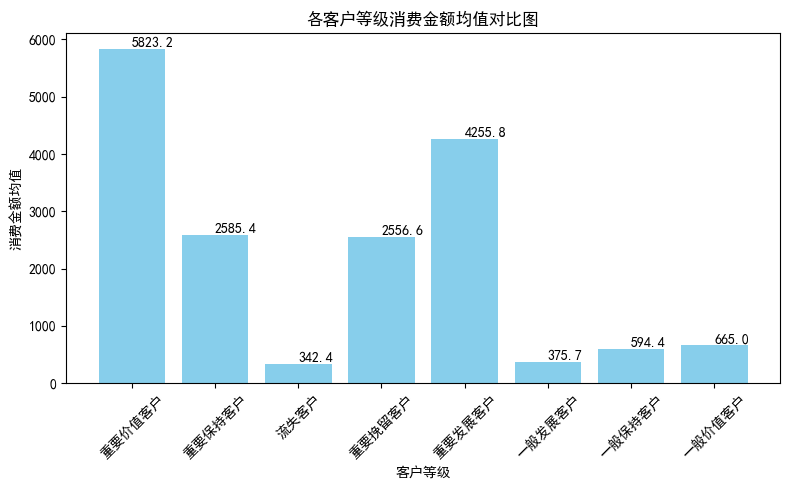

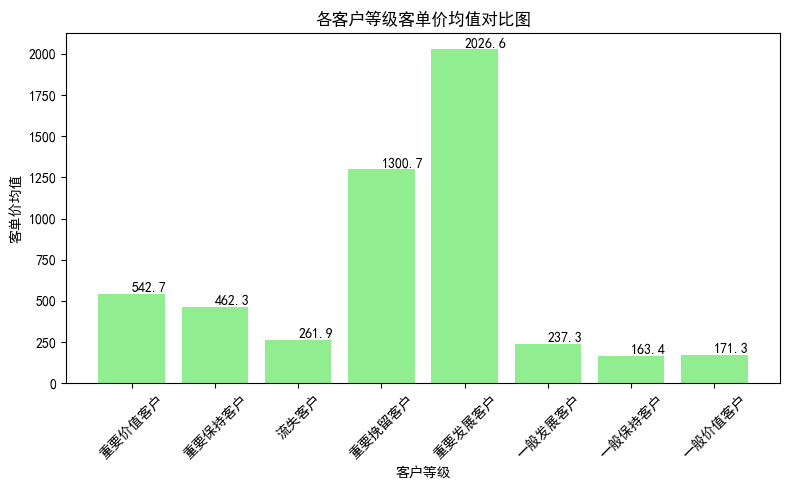

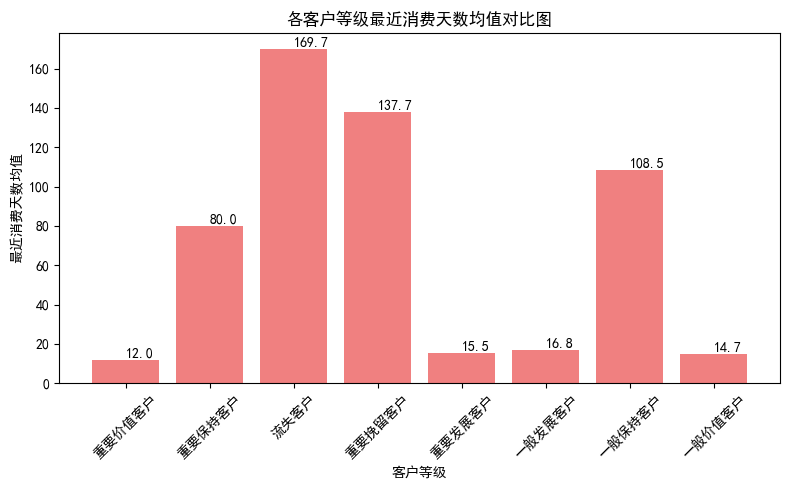

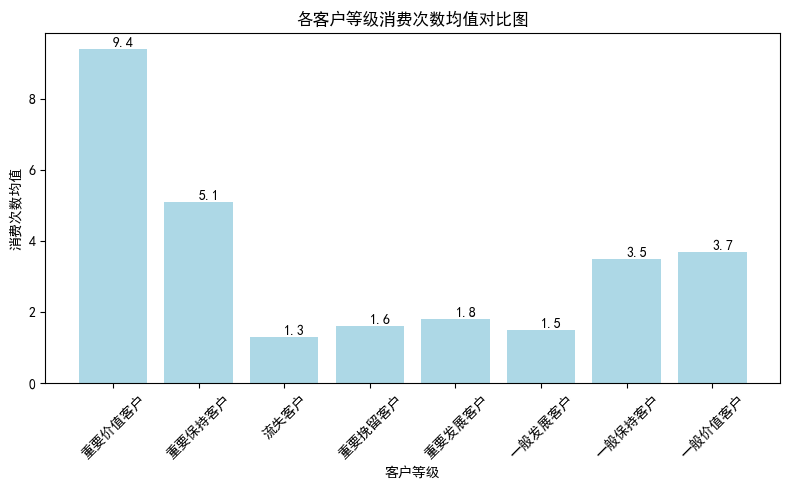

In [25]:
import matplotlib.pyplot as plt

# 消费金额均值对比图
plt.figure(figsize=(8, 5))
bars = plt.bar(RFM_level.index, RFM_level['消费金额']['均值'], color='skyblue')
plt.xlabel('客户等级')
plt.ylabel('消费金额均值')
plt.title('各客户等级消费金额均值对比图')
plt.xticks(rotation=45)
plt.tight_layout()

# 在柱状图上标上数字
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # va: vertical alignment
plt.show()

# 客单价均值对比图
plt.figure(figsize=(8, 5))
bars = plt.bar(RFM_level.index, RFM_level[('客单价', '均值')], color='lightgreen')
plt.xlabel('客户等级')
plt.ylabel('客单价均值')
plt.title('各客户等级客单价均值对比图')
plt.xticks(rotation=45)
plt.tight_layout()

# 在柱状图上标上数字
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')
plt.show()

# 最近消费天数均值对比图
plt.figure(figsize=(8, 5))
bars = plt.bar(RFM_level.index, RFM_level['最近消费天数']['均值'], color='lightcoral')
plt.xlabel('客户等级')
plt.ylabel('最近消费天数均值')
plt.title('各客户等级最近消费天数均值对比图')
plt.xticks(rotation=45)
plt.tight_layout()

# 在柱状图上标上数字
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')
plt.show()

# 消费次数均值对比图
plt.figure(figsize=(8, 5))
bars = plt.bar(RFM_level.index, RFM_level['消费次数']['均值'], color='lightblue')
plt.xlabel('客户等级')
plt.ylabel('消费次数均值')
plt.title('各客户等级消费次数均值对比图')
plt.xticks(rotation=45)
plt.tight_layout()

# 在柱状图上标上数字
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')
plt.show()

In [26]:
# 按照R、F、M权重3:3:4综合评分 
RFM_weight = RFM[['R_scores', 'F_scores', 'M_scores']]
RFM_weight['Scores'] = 0.3 * RFM_weight['R_scores'] + 0.3 * RFM_weight['F_scores'] + 0.4 * RFM_weight['M_scores']

def score2value(x):
    if x >= 4.2:
        x = '高价值客户'
    elif 4.2 > x >= 3.4:
        x = '较高价值客户'
    elif 3.4 > x >= 2.6:
        x = '中等价值客户'
    elif 2.6 > x >= 1.8:
        x = '一般价值客户'
    else:
        x = '低价值客户'
    return x
RFM_weight['Value'] = RFM_weight['Scores'].apply(lambda x : score2value(x))


In [27]:
# 选出每个客户的消费总金额，下单总数，下单的产品总数
RFM_weight = pd.concat([RFM_weight.Value, data_temp, R_days, F],axis=1)
RFM_weight.columns = ['客户等级', '消费金额', '购买商品总量', '订单总量', '最近消费天数', '消费次数']
RFM_weight_level = customer_level_statistic(RFM_weight)
RFM_weight_level

消费金额                    购买商品总量                  订单总量               \
            均值         总量     占比      均值       总量     占比    均值    总量     占比   
客户等级                                                                          
高价值客户   7540.6  5580036.2  62.8%  4305.9  3186360  61.8%  13.4  9879  53.3%   
较高价值客户  2175.7  1707921.1  19.2%  1260.5   989531  19.2%   4.6  3638  19.6%   
中等价值客户  1125.6   874595.8   9.8%   695.0   540014  10.5%   2.8  2179  11.8%   
一般价值客户   496.0   494960.9   5.6%   298.1   297486   5.8%   1.7  1662   9.0%   
低价值客户    221.3   229694.8   2.6%   133.5   138611   2.7%   1.1  1174   6.3%   

        客户等级        最近消费天数  消费次数    客单价  
          数量     占比     均值    均值     均值  
客户等级                                     
高价值客户    740  17.1%   10.9  11.6  564.8  
较高价值客户   785  18.1%   37.6   4.3  469.5  
中等价值客户   777  17.9%   61.0   2.6  401.4  
一般价值客户   998  23.0%   99.3   1.6  297.8  
低价值客户   1038  23.9%  205.2   1.1  195.7

In [28]:
#k-means聚类
# 合并数据
k_data = pd.concat([R_days, F, M], axis=1)
k_data.columns = ['R', 'F', 'M']

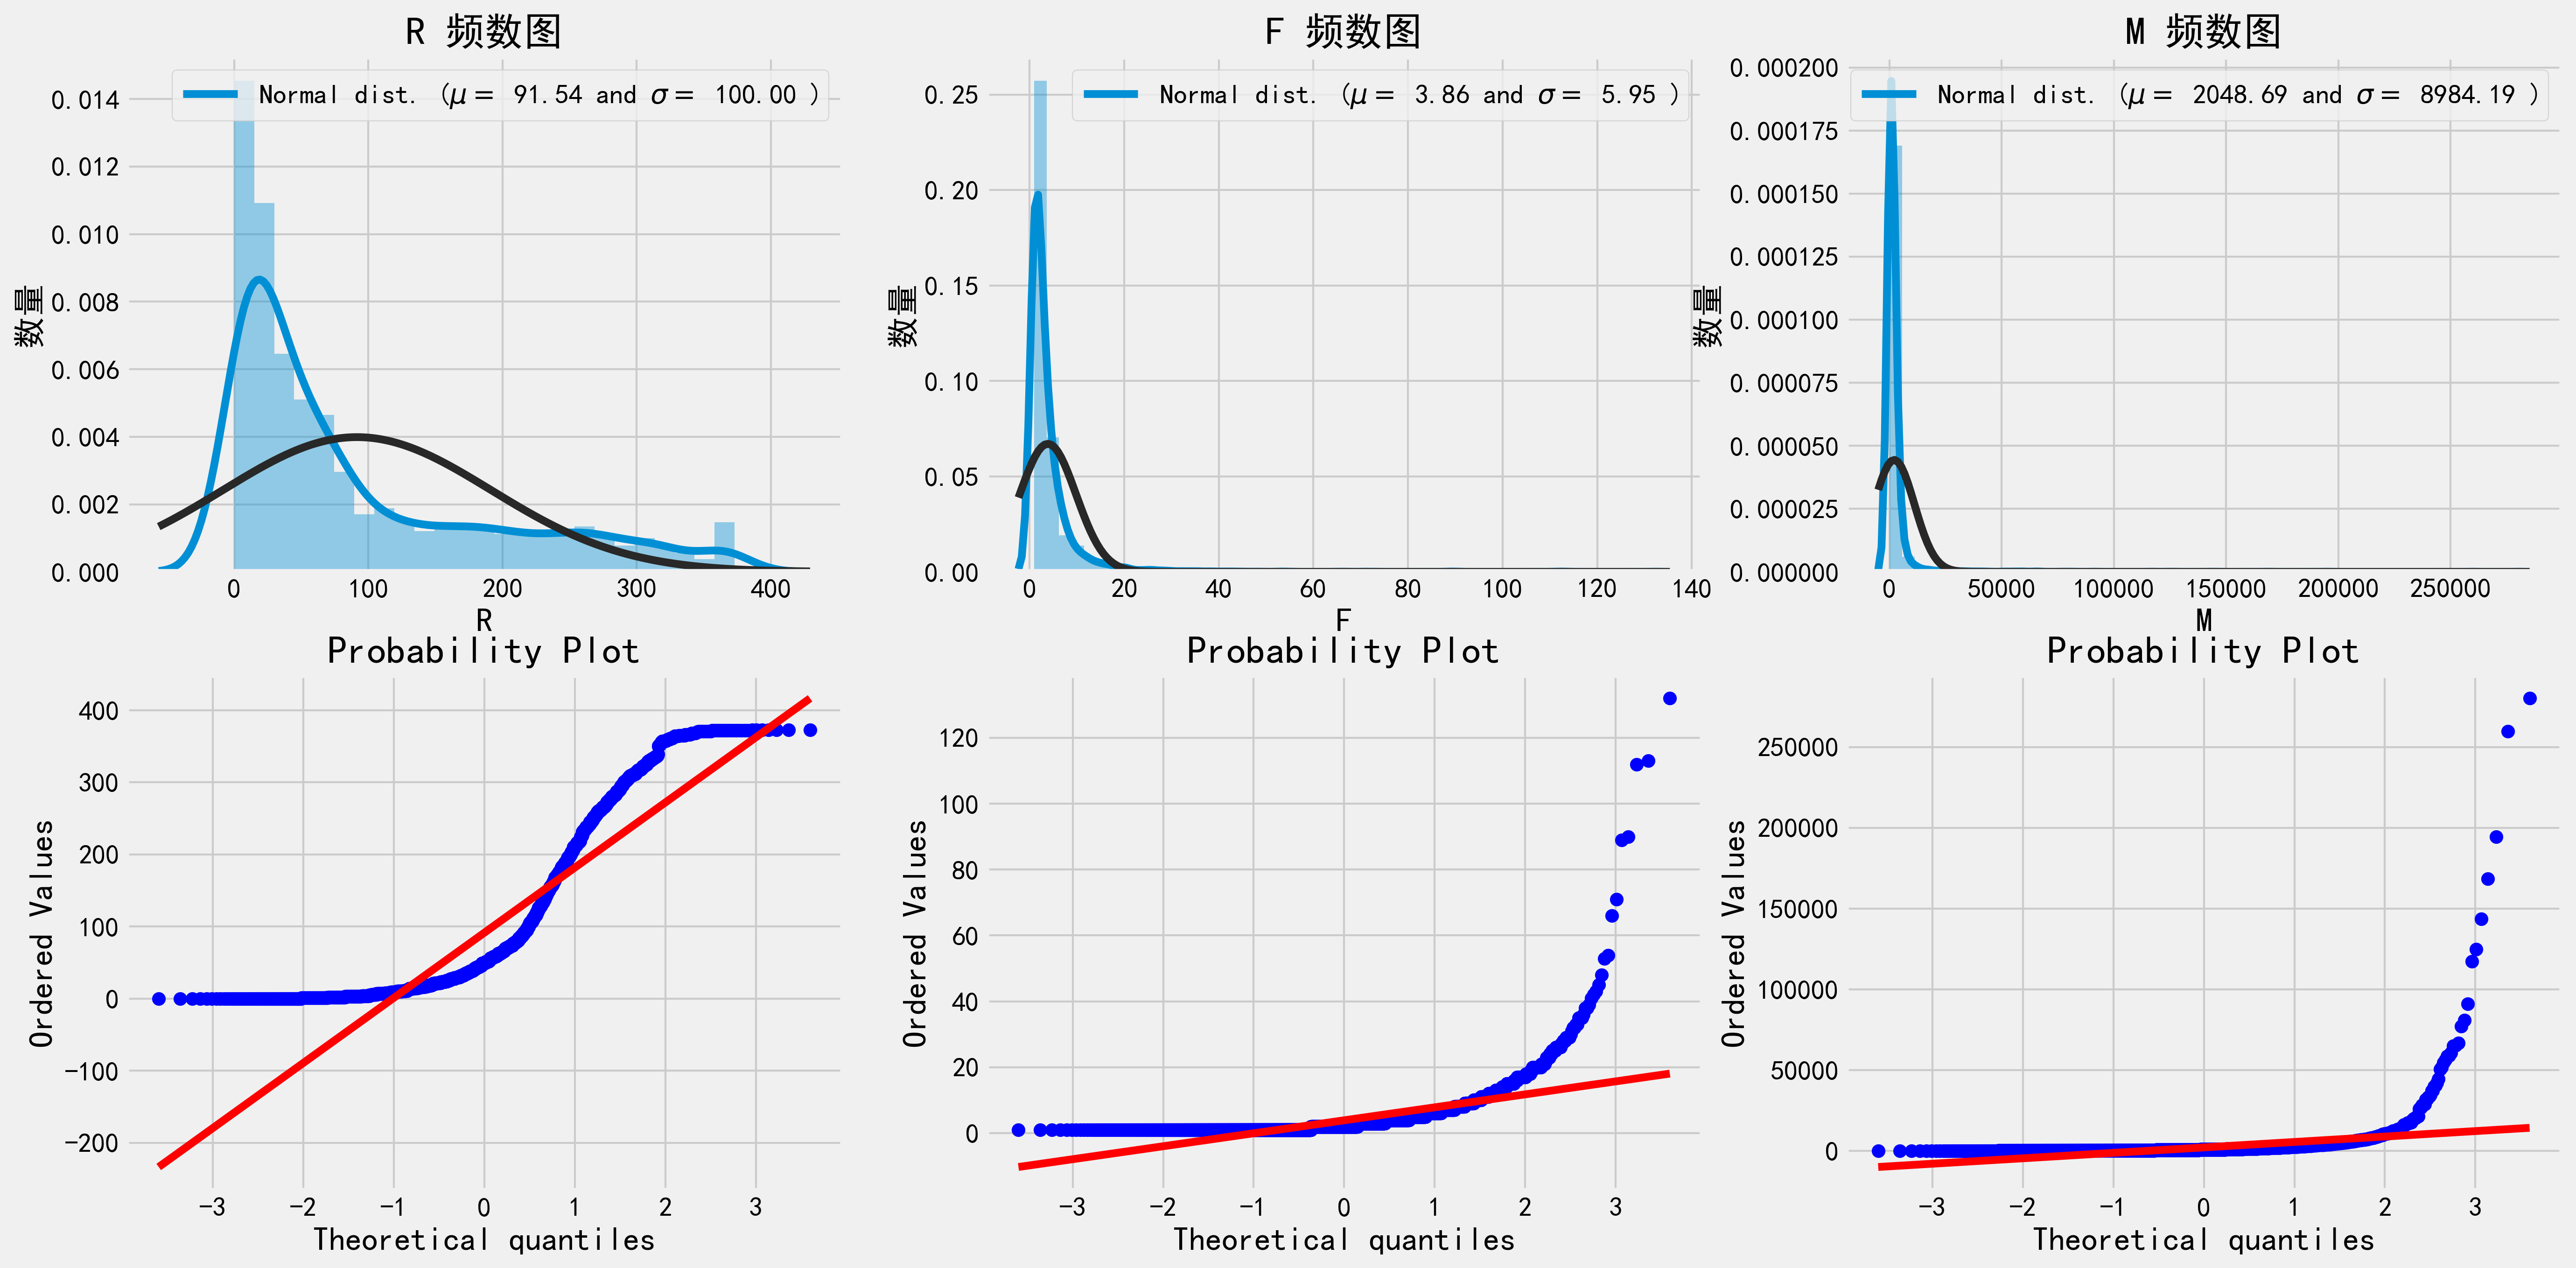

In [29]:
from scipy import stats
from scipy.stats import norm, skew 
plt.style.use('fivethirtyeight')

def draw_dist_prob(data):    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), dpi=300)
    
    for i,j in enumerate(['R', 'F', 'M']):
        sns.distplot(data[j], fit=norm, ax=ax[0][i])
        (mu, sigma) = norm.fit(data[j])
        ax[0][i].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
        ax[0][i].set_ylabel('数量')
        ax[0][i].set_title('{} 频数图'.format(j))
    
        stats.probplot(data[j], plot=ax[1][i])

draw_dist_prob(k_data)

In [30]:
# 查看偏度、峰度
pd.DataFrame([i for i in zip(k_data.columns, k_data.skew(), k_data.kurt())], 
             columns=['特征', '偏度', '峰度'])

,特征,偏度,峰度
0,R,1.246048,0.430576
1,F,8.826137,133.359676
2,M,19.339368,478.684289


In [31]:
# R中存在0值，进行box-cox转换时存在0值会将其转变成无穷大，所以将所有的值加上一个很小的数全部变成正数
k_data.R = k_data.R + 0.0001
# boxcox转换
k_data_bc = k_data.copy()
for i in k_data_bc.columns:  # 自动计算λ
    k_data_bc[i], _ = stats.boxcox(k_data_bc[i])
# 查看偏度、峰度
pd.DataFrame([i for i in zip(k_data_bc.columns, k_data_bc.skew(), k_data_bc.kurt())], 
             columns=['特征', '偏度', '峰度'])

,特征,偏度,峰度
0,R,-0.123254,-0.465704
1,F,0.152343,-1.241836
2,M,-0.015718,0.485904


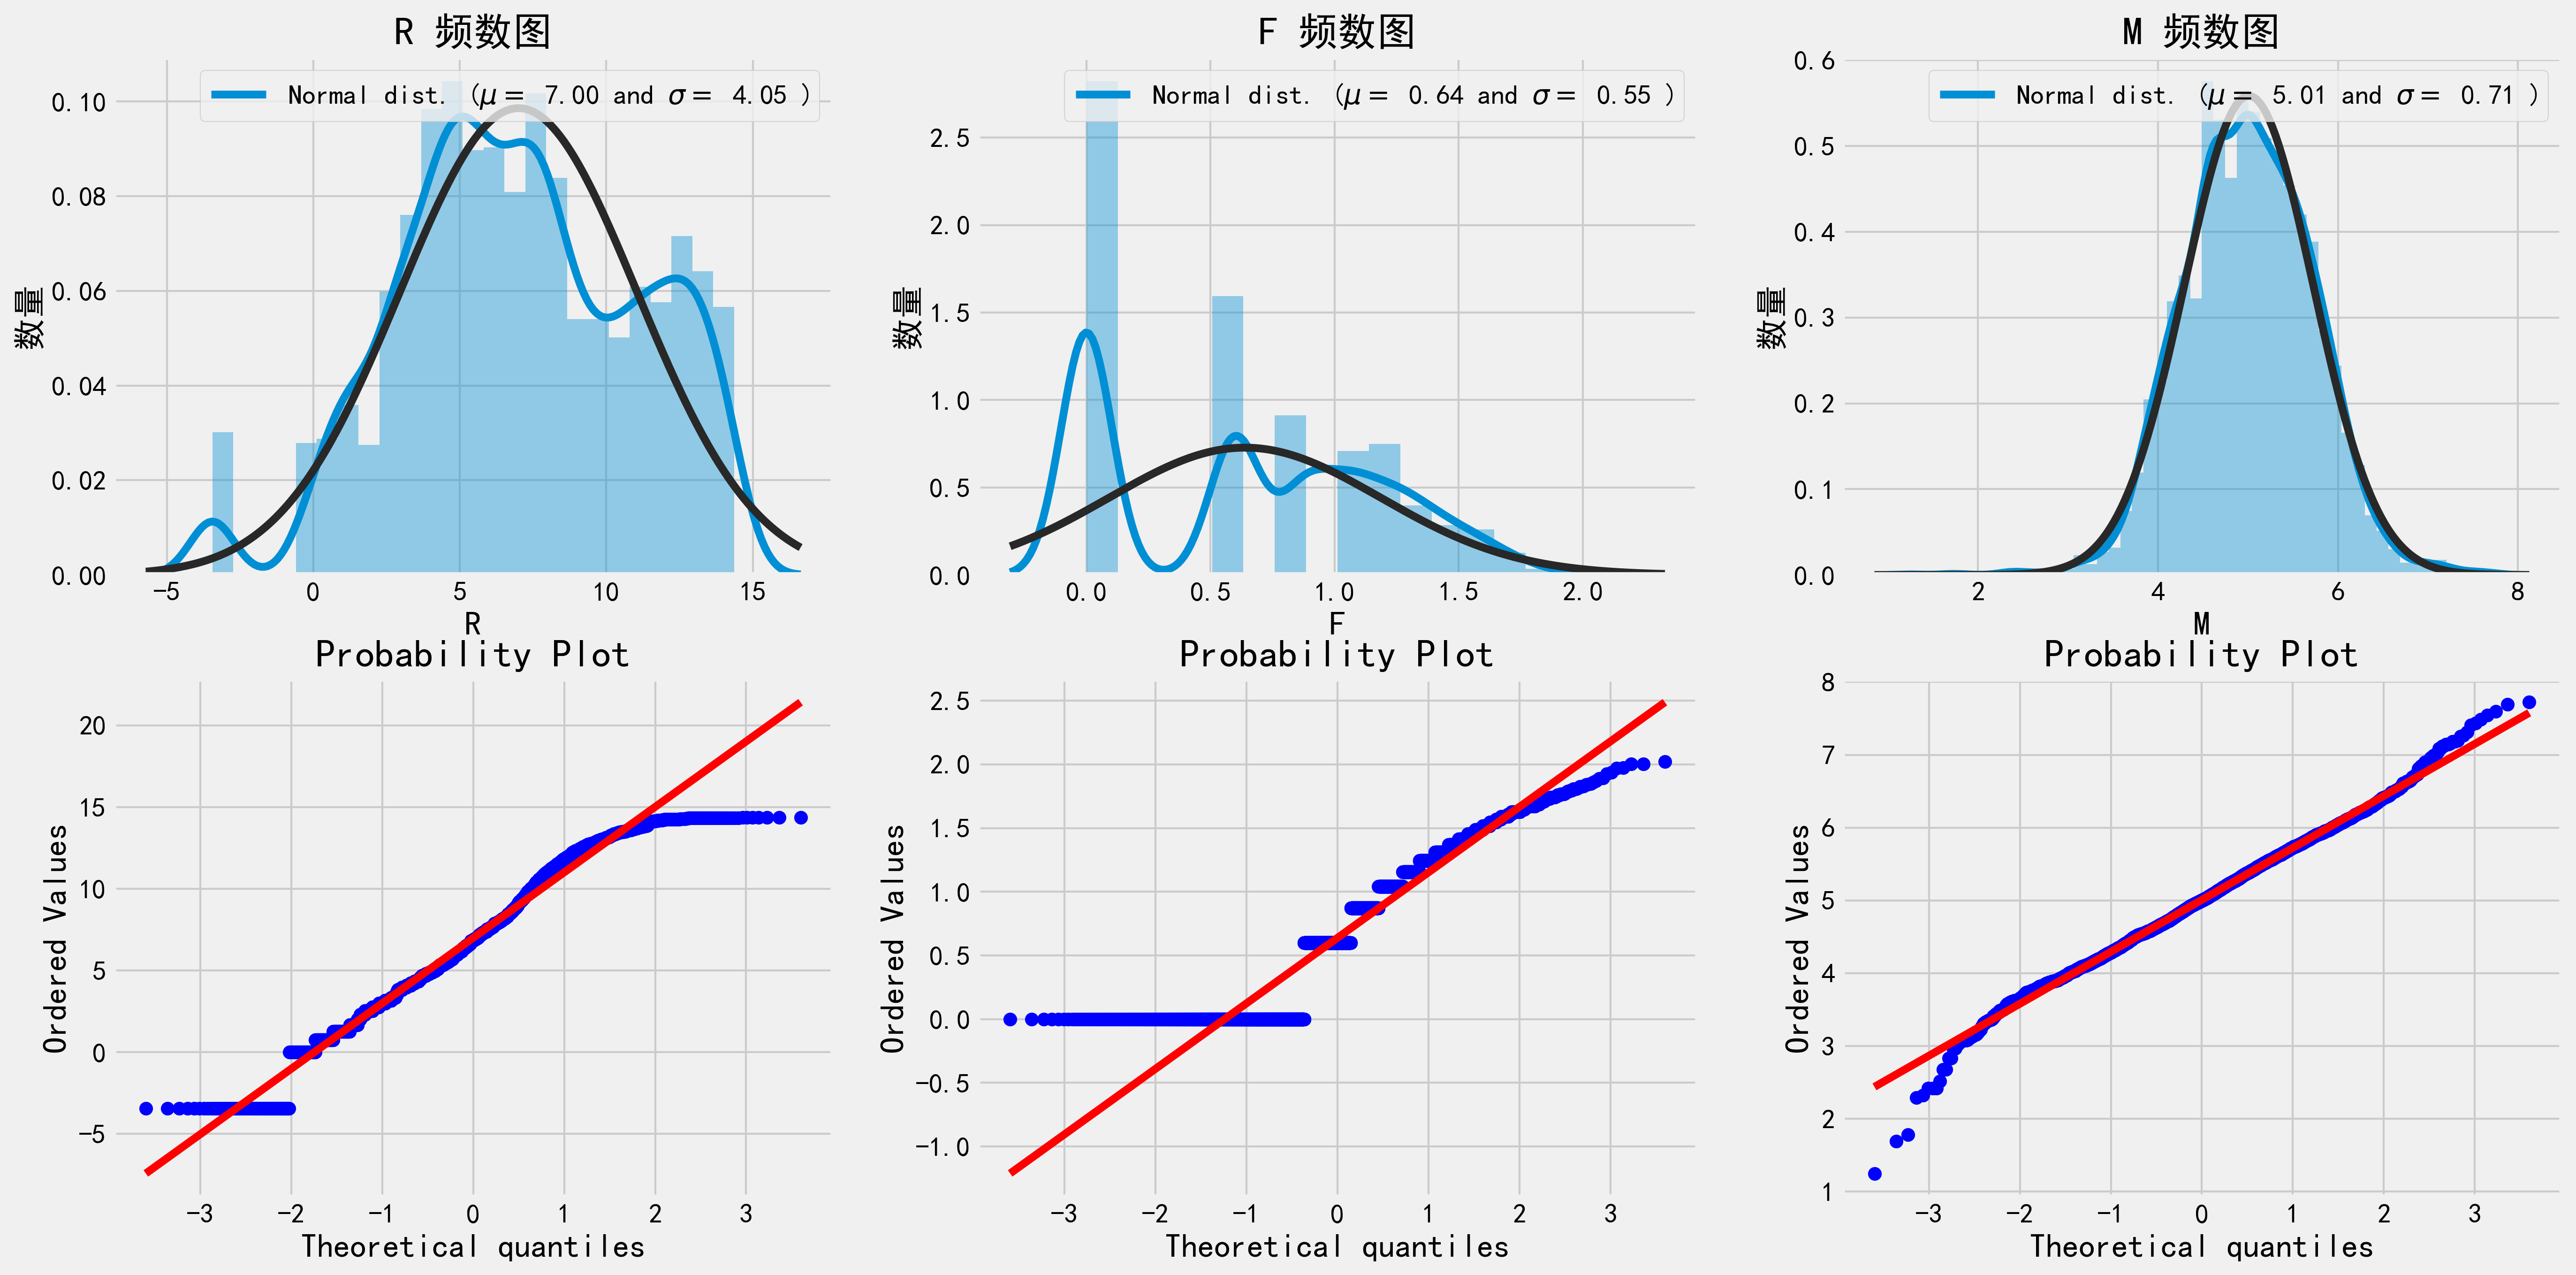

In [32]:
draw_dist_prob(k_data_bc)

In [33]:
# K-means 的本质是基于欧式距离的数据划分算法，均值和方差大的维度将对数据的聚类产生决定性影响。
# 使用标准化对数据进行预处理可以减小不同量纲的影响。
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
standard_scaler.fit(k_data_bc)
data_scaler = standard_scaler.transform(k_data_bc)
k_data_scaler = pd.DataFrame(data_scaler, columns = ['R', 'F', 'M'], index = k_data.index)
k_data_scaler.head()

,R,F,M
CustomerID,,,
12346.0,1.657406,-1.164366,3.140439
12347.0,-1.730016,1.230484,1.378499
12348.0,0.255593,0.734792,0.753480
12349.0,-0.656450,-1.164366,0.736908
12350.0,1.599973,-1.164366,-0.586537


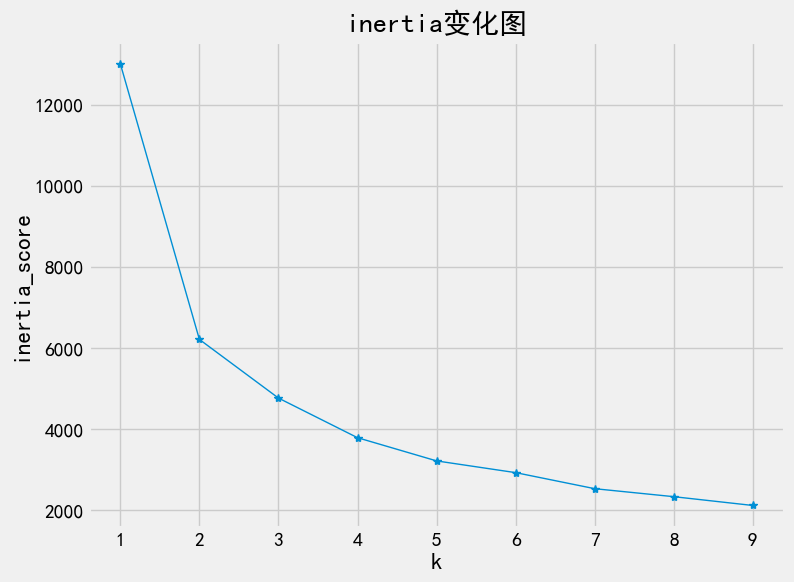

In [34]:
#k-means建模
#k值选取
#肘部法则选取k
from sklearn.cluster import KMeans
# 选择K的范围 ，遍历每个值进行评估
inertia_list = []
for k in range(1,10):
    model = KMeans(n_clusters = k, max_iter = 500, random_state = 12)
    kmeans = model.fit(k_data_scaler)
    inertia_list.append(kmeans.inertia_)

# 绘图
fig,ax = plt.subplots(figsize=(8,6))    
ax.plot(range(1,10), inertia_list, '*-', linewidth=1)
ax.set_xlabel('k')
ax.set_ylabel("inertia_score") 
ax.set_title('inertia变化图')
plt.show()

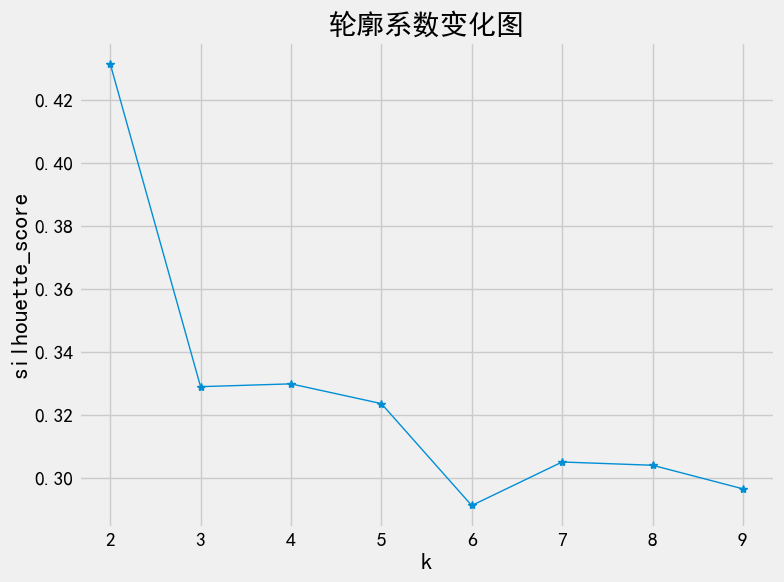

In [72]:
from sklearn import metrics

label_list = []
silhouette_score_list = []
for k in range(2,10):
    model = KMeans(n_clusters = k, max_iter = 500, random_state=123 )
    kmeans = model.fit(k_data_scaler)
    silhouette_score = metrics.silhouette_score(k_data_scaler, kmeans.labels_)  # 轮廓系数
    silhouette_score_list.append(silhouette_score)
    label_list.append({k: kmeans.labels_})
    
# 绘图
fig,ax = plt.subplots(figsize=(8,6))    
ax.plot(range(2,10), silhouette_score_list, '*-', linewidth=1)
ax.set_xlabel('k')
ax.set_ylabel("silhouette_score") 
ax.set_title('轮廓系数变化图')
plt.show()

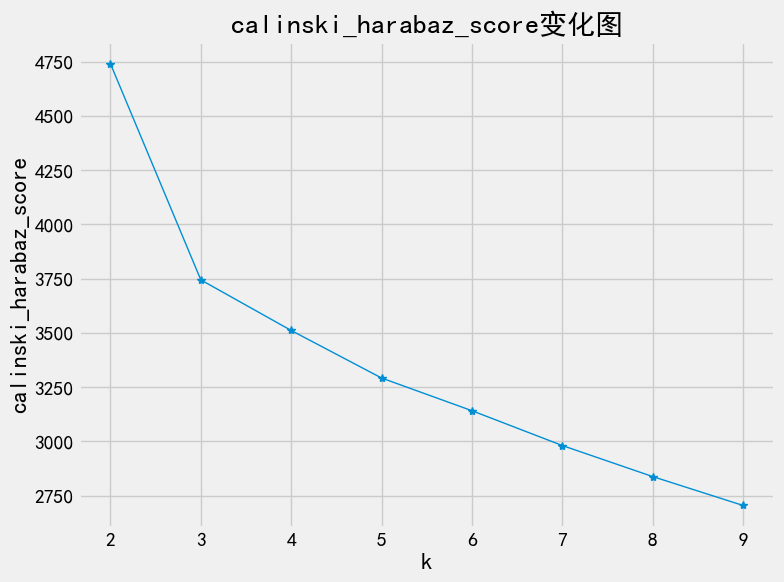

In [75]:
calinski_harabaz_score_list = []
for i in range(2,10):
    model = KMeans(n_clusters = i, random_state=1234)
    kmeans = model.fit(k_data_scaler)
    calinski_harabaz_score = metrics.calinski_harabasz_score(k_data_scaler, kmeans.labels_)
    calinski_harabaz_score_list.append(calinski_harabaz_score)

# 绘图
fig,ax = plt.subplots(figsize=(8,6))    
ax.plot(range(2,10), calinski_harabaz_score_list, '*-', linewidth=1)
ax.set_xlabel('k')
ax.set_ylabel("calinski_harabaz_score") 
ax.set_title('calinski_harabaz_score变化图')
plt.show()

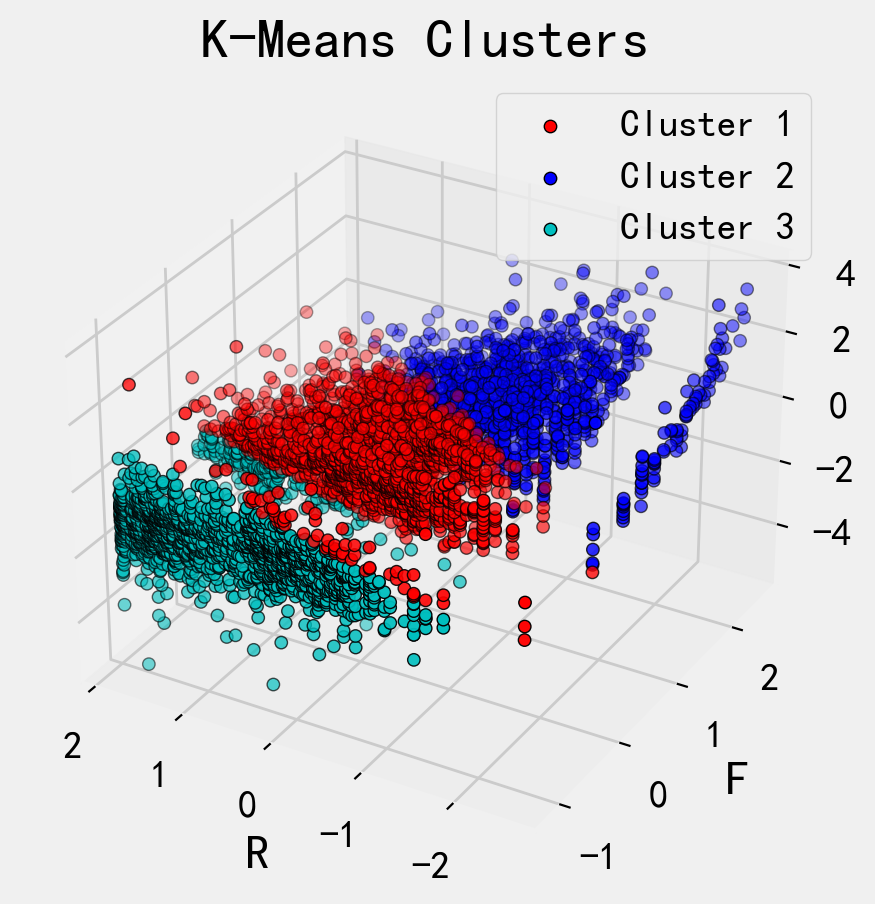

In [87]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 假设k_data_scaler是已经处理好的DataFrame
model = KMeans(n_clusters=3, random_state=12345)
kmeans = model.fit(k_data_scaler[['R', 'F', 'M']])
k_data['label'] = kmeans.labels_
k_data_scaler['label'] = kmeans.labels_

fig = plt.figure(figsize=(8, 5), dpi=200)
ax = fig.add_subplot(111, projection='3d')  # 正确创建3D坐标轴

# 绘制散点图
ax.scatter(k_data_scaler.query("label == 0").R, k_data_scaler.query("label == 0").F, 
           k_data_scaler.query("label == 0").M, edgecolor='k', color='r', label='Cluster 1')
ax.scatter(k_data_scaler.query("label == 1").R, k_data_scaler.query("label == 1").F, 
           k_data_scaler.query("label == 1").M, edgecolor='k', color='b', label='Cluster 2')
ax.scatter(k_data_scaler.query("label == 2").R, k_data_scaler.query("label == 2").F, 
           k_data_scaler.query("label == 2").M, edgecolor='k', color='c', label='Cluster 3')

ax.legend()
ax.invert_xaxis()
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
ax.set_title('K-Means Clusters')
plt.show()

In [131]:
# 选出每个客户的消费总金额，下单总数，下单的产品总数
data_temp = data.groupby('CustomerID').agg({'Quantity':np.sum, 'InvoiceNo':'nunique'})
kmeans_data = pd.concat([k_data, data_temp],axis=1)
kmeans_data.columns = ['最近消费天数', '消费次数', '消费金额', '客户等级', '购买商品总量','订单总量']
kmeans_level = customer_level_statistic(kmeans_data)
kmeans_level

消费金额                    购买商品总量                  订单总量                \
          均值         总量     占比      均值       总量     占比    均值     总量     占比   
客户等级                                                                         
1     5923.7  6622656.9  74.5%  3384.4  3783773  73.4%  10.6  11893  64.2%   
0     1103.3  1752106.7  19.7%   665.3  1056537  20.5%   3.0   4782  25.8%   
2      314.0   512445.3   5.8%   191.0   311692   6.0%   1.1   1857  10.0%   

      客户等级        最近消费天数 消费次数    客单价  
        数量     占比     均值   均值     均值  
客户等级                                  
1     1118  25.8%   15.9  9.4  556.9  
0     1588  36.6%   71.2  2.8  366.4  
2     1632  37.6%  163.1  1.1  276.0

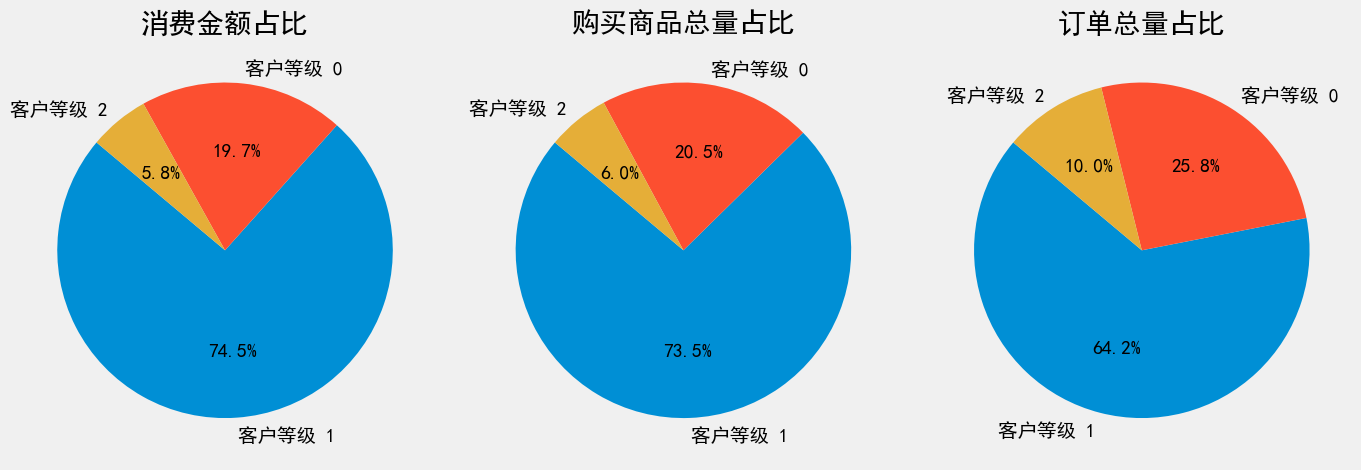

In [133]:
import matplotlib.pyplot as plt

# 客户等级的消费金额占比
labels = ['客户等级 1', '客户等级 0', '客户等级 2']
sizes_consumption = [74.5, 19.7, 5.8]  # 消费金额占比
sizes_products = [73.4, 20.5, 6.0]  # 购买商品总量占比
sizes_orders = [64.2, 25.8, 10.0]  # 订单总量占比

# 绘制消费金额占比饼图
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.pie(sizes_consumption, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('消费金额占比')

# 绘制购买商品总量占比饼图
plt.subplot(1, 3, 2)
plt.pie(sizes_products, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('购买商品总量占比')

# 绘制订单总量占比饼图
plt.subplot(1, 3, 3)
plt.pie(sizes_orders, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('订单总量占比')

plt.tight_layout()
plt.show()

                    InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

                     Quantity  UnitPrice  CustomerID         Country  
InvoiceDate                                                           
2010-12-01 08:26:00         6       2.55     17850.0  United Kingdom  
2010-12-01 08:26:00         6       3.39     17850.0  United Kingdom  
2010-12-01 08:26:00         8       2.75     17850.0  United Kingdom  
2010-12-01 08:26:00         6       3.39     17850.0  United Kingdom  
2010-12-01 08

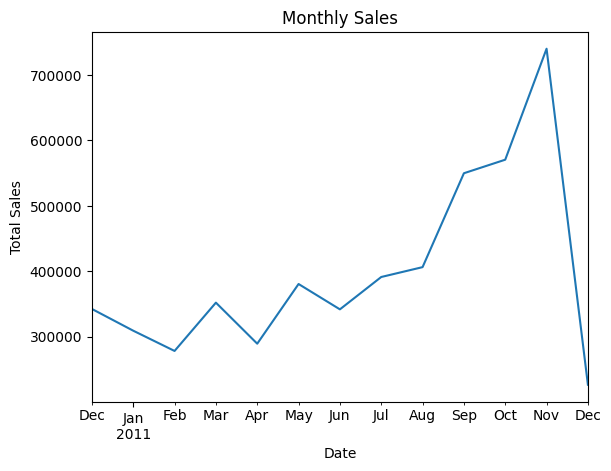

ADF Statistic: -1.539206
p-value: 0.514035


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# 数据集文件路径
file_path = r'D:\2067455485\FileRecv\data.csv'

# 使用检测到的编码读取文件
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# 将InvoiceDate转换为datetime类型，并设置为索引
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate', inplace=True)

# 检查数据
print(df.head())

# 假设我们需要分析的列是'Quantity'，表示销售量
# 确保'Quantity'列存在
if 'Quantity' in df.columns:
    # 将数据聚合到月级别
    monthly_sales = df['Quantity'].resample('ME').sum()  # 使用'ME'代替'M'

    # 检查聚合后的数据
    print(monthly_sales.head())

    # 绘制时间序列图
    monthly_sales.plot()
    plt.title('Monthly Sales')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.show()

    # 检查数据平稳性
    result = adfuller(monthly_sales)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])